In [1]:
from turtledemo.clock import tick

import pandas as pd
import numpy as np
from pandas import DataFrame
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
firms = pd.read_excel('https://github.com/0xMarmelade/FIN-429-Sustainable-finance/raw/main/firm_names.xlsx')
scores = pd.read_excel('https://github.com/0xMarmelade/FIN-429-Sustainable-finance/raw/main/Soc.xlsx', index_col = 0)
returns = pd.read_excel('https://github.com/0xMarmelade/FIN-429-Sustainable-finance/raw/main/monthlyreturns.xlsx', index_col = 0)
market_values = pd.read_excel('https://github.com/0xMarmelade/FIN-429-Sustainable-finance/raw/main/size.xlsx', index_col=0)
eu_risk_free_rates = pd.read_excel('https://github.com/0xMarmelade/FIN-429-Sustainable-finance/raw/main/eurf.xlsx', index_col=0)
eu_countrycodes = ['AL','AD', 'AM','AT','BA','BE','BG','CH','CY','DE','DK','EE','ES','FI','FR','GE', 'GB','GR','HR','HU','IE','IS','IT','LT','LV','MC','MK','MT','NL','NO','PL','PT','RO','RS', 'RU','SE','SI', 'TR', 'UA', 'MD', 'LI']

# Data cleaning and selection
Transposing table to get firms as rows, reset columns to dates

In [3]:
scores = scores.transpose()
scores.index.rename('ISIN', inplace=True)

firms.set_index("ISIN", inplace=True)

Join Social scores to firm's names and locations
Filter on firms that are located in Europe.
Variable  `eu_firm_names` containes the relevant firm names for our analysis.

In [4]:
scores = scores.join(firms, how="left", on="ISIN")
scores = scores[scores["Country"].isin(eu_countrycodes)]


Remove firms with unusual data:
- GB00B45TWN62 all empty or NaN
- GB00B979H674 NaN, 0 and one valid datapoint)
- DE000A2YPGA9 Only traded recently with abnormaly high volatility
- GB0031718066 Only has few data points and stratospherous returns
- IE00BLNN3691 (Weatherford International Ltd. Equity) has a weird extremely high return in end 2019. WILL KEEP FOR
df.loc[~df.index.duplicated(), :]

In [282]:
scores.dropna(how='all', inplace=True)
scores.drop(['GB00B45TWN62', 'GB00B979H674', 'NL0010157558', 'DE000A2YPGA9', 'GB0031718066'], axis='index', inplace=True)
eu_firm_names = scores.index

KeyError: "['GB00B45TWN62' 'GB00B979H674' 'NL0010157558' 'DE000A2YPGA9'\n 'GB0031718066'] not found in axis"

In [266]:
eu_firm_names = eu_firm_names[~eu_firm_names.duplicated()]


In [271]:
eu_firm_returns = returns[eu_firm_names]
eu_firm_market_values = market_values[eu_firm_names]
eu_firm_returns.head()

,AT000000STR1,AT00000VIE62,AT0000606306,AT0000642806,AT0000652011,AT0000720008,AT0000730007,AT0000743059,AT0000746409,AT0000767553,...,RU000A0DKVS5,US68370R1095,US69338N2062,US7171402065,RU000A0JRKT8,RU000A0B6NK6,US92927K1025,US97263M1099,US98387E2054,VGG1890L1076
2002-01-31,NaN,0.004704,NaN,NaN,0.044299,0.028358,-0.031736,0.017735,0.011466,-0.000433,...,NaN,0.009666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-02-28,NaN,0.056424,NaN,NaN,-0.053178,0.016936,-0.100985,0.001924,0.036171,0.105286,...,NaN,0.143159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-03-31,NaN,0.013897,NaN,NaN,0.102579,-0.055194,0.000246,0.012976,-0.027588,0.141121,...,NaN,0.042653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-04-30,NaN,0.099059,NaN,NaN,0.130746,0.032542,0.279030,0.131208,0.052367,-0.127104,...,NaN,0.012889,NaN,NaN,NaN,NaN,NaN,0.069556,NaN,NaN
2002-05-31,NaN,0.085816,NaN,NaN,0.198617,0.019151,0.177818,-0.015824,0.103447,0.035419,...,NaN,-0.289719,NaN,NaN,NaN,NaN,NaN,-0.033756,NaN,NaN


IE00BLNN3691    1.342984
GB0031718066    0.091334
NL0012969182    0.050649
PLDINPL00011    0.047950
PTBES0AM0007    0.041001
dtype: float64

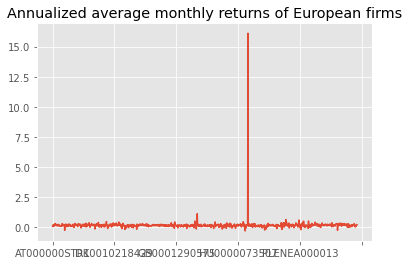

In [23]:
(eu_firm_returns.mean() * 12).plot(title='Annualized average monthly returns of European firms')
eu_firm_returns.mean().sort_values(ascending=False).head(5)

## Question 1
Compute and report the annualized average return and annualized volatility for all
individual assets. Compute the correlation between individual average returns and
volatility and comment on the observed correlation. (5 points)

In [8]:
(eu_firm_returns.mean() * 12).corr(eu_firm_returns.std())

0.9791372044057501

## Question 2
Form an equally-weighted and value-weighted portfolio with monthly rebalancing. Report the following statistics for both portfolios: annualized average return, annualized volatility, minimum return, maximum return, and Sharpe ratio. Plot the time series of returns for both portfolios. (10 points)


In [9]:
def portfolio_stats(weighted_returns: DataFrame, name: str) -> DataFrame:

    by_month_returns = weighted_returns.sum(axis='columns')
    
    portfolio = {}
    portfolio['AAR'] = by_month_returns.mean() * 12
    portfolio['Annualized volatility'] = by_month_returns.std() * math.sqrt(12)
    portfolio['Min return'] = by_month_returns.min()
    portfolio['Max return'] = by_month_returns.max()
    portfolio['Sharpe ratio'] = (portfolio['AAR'] - eu_risk_free_rates.values.mean()) / (portfolio['Annualized volatility'])

    return pd.DataFrame(portfolio, index=[name])

### Equally weighted portfolio

,AAR,Annualized volatility,Min return,Max return,Sharpe ratio
Equally weighted portfolio,0.15157,0.232718,-0.252579,0.359201,0.646915


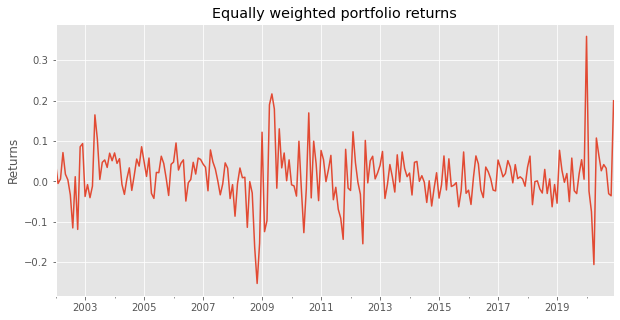

In [10]:
equal_weights_returns: pd.DataFrame = pd.DataFrame(index=eu_firm_returns.index, columns=eu_firm_returns.columns)

for index, row in eu_firm_returns.iterrows():
   equal_weights_returns.loc[index] = row.div(row.count()).transpose()
   

equal_weights_portfolio_stats = portfolio_stats(equal_weights_returns, 'Equally weighted portfolio')
equal_weights_returns.sum(axis='columns').plot(title='Equally weighted portfolio returns', figsize=(10,5)).set(ylabel='Returns')
equal_weights_portfolio_stats

,AAR,Annualized volatility,Min return,Max return,Sharpe ratio
Value-weighted portfolio,0.091009,0.185907,-0.181573,0.191154,0.484052


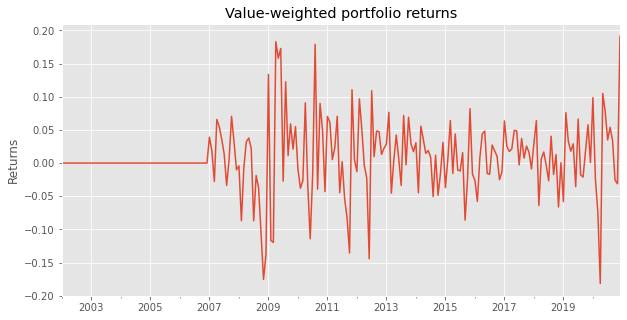

In [11]:
value_weights = pd.DataFrame(index=eu_firm_returns.index, columns=eu_firm_returns.columns)

for index, row in eu_firm_market_values.iterrows():
   value_weights.loc[index] = row.div(row.sum()).transpose()

value_weighted_portfolio = eu_firm_returns.mul(value_weights)
value_weighted_portfolio.sum(axis='columns').plot(title='Value-weighted portfolio returns', figsize=(10,5)).set(ylabel='Returns')
value_weighted_portfolio_stats = portfolio_stats(value_weighted_portfolio, 'Value-weighted portfolio')
value_weighted_portfolio_stats

<AxesSubplot:>

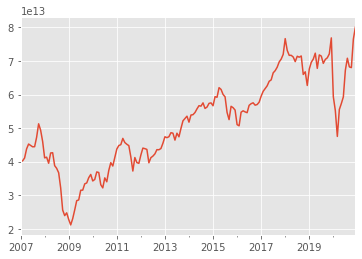

In [12]:
market_values.sum(axis=1).plot()

### Plotting Equal weighted and Value weighted portfolio.
(Correlation between returns is computed from 2007, at what point firm size data is available)

0.9442075725466111

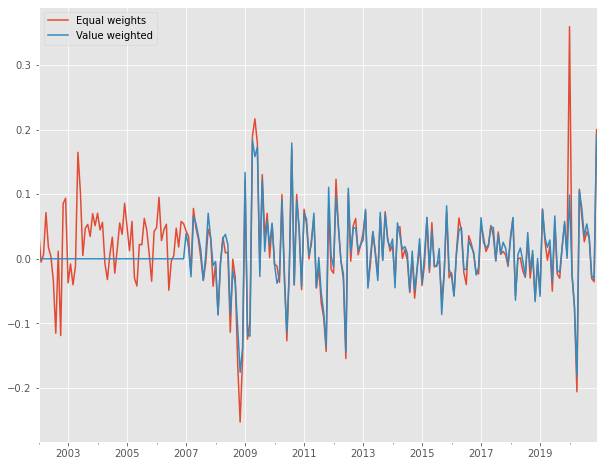

In [13]:
value_weighted_portfolio.sum(axis=1).plot(label='Value weighted', legend=True, ax=equal_weights_returns.sum(axis='columns').plot(label='Equal weights', legend=True), figsize=(10,8))
value_weighted_portfolio.sum(axis=1)[value_weighted_portfolio.index.year > 2006].corr(equal_weights_returns.sum(axis=1))

In [14]:
portfolios_question_2 = value_weighted_portfolio_stats.append(equal_weights_portfolio_stats)
portfolios_question_2

,AAR,Annualized volatility,Min return,Max return,Sharpe ratio
Value-weighted portfolio,0.091009,0.185907,-0.181573,0.191154,0.484052
Equally weighted portfolio,0.151570,0.232718,-0.252579,0.359201,0.646915


### Question 3

Supposed that you invested 100% of your wealth in the asset with the highest annualized average return computed in point 1. Compare the annualized average return and annualized volatility of this one-asset portfolio with the equally-weighted and value weighted portfolios? What explains the differences between a one-asset portfolio and a portfolio composed of many stocks? What if you invest 100% of your wealth in the asset with the highest average return computed over the first 2 years? (10 points)


In [15]:
stock = eu_firm_returns['IE00BLNN3691']
(eu_firm_returns.mean() * 12).sort_values(ascending=False).head(5)

IE00BLNN3691    16.115811
GB0031718066     1.096009
NL0012969182     0.607790
PLDINPL00011     0.575401
PTBES0AM0007     0.492010
dtype: float64

In [16]:
pd.DataFrame(
    {
        'AAR': eu_firm_returns['NL0012969182'].mean() * 12,
        'Annualized volatility': eu_firm_returns['NL0012969182'].std() * math.sqrt(12),
        'Min return': eu_firm_returns['NL0012969182'].min(),
        'Max return': eu_firm_returns['NL0012969182'].max(),
        'Sharpe ratio': (eu_firm_returns['NL0012969182'].mean() - eu_risk_free_rates.values.mean()) / (eu_firm_returns['NL0012969182'].std())
    }, index=['NL0012969182']
)

,AAR,Annualized volatility,Min return,Max return,Sharpe ratio
NL0012969182,0.60779,0.460468,-0.214925,0.338791,0.373353


In [17]:
portfolios_question_3 = pd.DataFrame({'One stockss': pd.Series({ 'AAR': stock.mean() * 12,
                                                                 'Annualized volatility': stock.std() * math.sqrt(12),
                                                                 'Min return': stock.min(),
                                                                 'Max return': stock.max(),
                                                                 'Sharpe ratio': stock.std() * math.sqrt(12) / stock.mean()
                                                                 })})
portfolios_question_3['Equally weighted'] = equal_weights_portfolio_stats.sum()
portfolios_question_3['Value weighted'] = value_weighted_portfolio_stats.sum()
portfolios_question_3

,One stockss,Equally weighted,Value weighted
AAR,16.115811,0.151570,0.091009
Annualized volatility,70.510748,0.232718,0.185907
Min return,-0.766423,-0.252579,-0.181573
Max return,307.324324,0.359201,0.191154
Sharpe ratio,52.503033,0.646915,0.484052


In [18]:
(eu_firm_returns.groupby(eu_firm_returns.index.year).mean()*12)

,AT000000STR1,AT00000VIE62,AT0000606306,AT0000642806,AT0000652011,AT0000720008,AT0000730007,AT0000743059,AT0000746409,AT0000767553,...,RU000A0DKVS5,US68370R1095,US69338N2062,US7171402065,RU000A0JRKT8,RU000A0B6NK6,US92927K1025,US97263M1099,US98387E2054,VGG1890L1076
2002,NaN,0.306446,NaN,NaN,0.169887,0.252310,0.262217,0.184160,0.083247,0.023147,...,NaN,0.477639,NaN,NaN,NaN,NaN,NaN,-0.221748,NaN,NaN
2003,NaN,0.323249,NaN,NaN,0.753658,0.264772,0.613093,0.536681,0.318189,1.834532,...,NaN,0.741105,NaN,NaN,NaN,NaN,NaN,0.029649,NaN,NaN
2004,NaN,0.582461,NaN,0.211912,0.672439,0.426791,0.639393,0.706795,0.744155,0.771471,...,NaN,0.559660,NaN,NaN,NaN,NaN,NaN,-0.196143,NaN,NaN
2005,NaN,-0.055784,0.326565,0.084026,0.063427,0.282858,0.431139,0.824229,0.477570,2.179011,...,0.815759,0.225543,NaN,NaN,NaN,NaN,NaN,0.382316,1.381299,NaN
2006,NaN,0.453082,0.751541,0.374008,0.343322,0.221664,0.717103,0.037514,0.549949,-0.668030,...,1.136763,0.569410,NaN,NaN,NaN,NaN,NaN,1.072307,0.252488,NaN
2007,-0.605900,0.241018,0.326164,-0.189311,0.011226,0.159484,0.294750,0.328453,0.357584,0.759174,...,0.070804,0.871406,0.445412,0.734967,NaN,0.355849,-0.059612,0.960397,0.181690,NaN
2008,-1.167048,-0.944873,-1.493852,-2.269745,-0.951814,-0.646609,-0.783649,-0.895742,-0.410166,-0.809417,...,-0.862358,-1.125232,-1.821807,-0.627070,NaN,-1.678191,-0.978928,-1.350329,-1.199776,NaN
2009,1.057087,0.615633,1.261488,3.476772,1.335889,0.447323,1.169371,0.761066,0.282779,1.595421,...,1.307298,1.218537,2.663720,1.008074,NaN,1.700227,0.846432,1.624165,2.109322,NaN
2010,-0.204700,0.257811,-0.049842,-0.008006,0.109261,-0.109288,0.343615,-0.145042,-0.255077,-0.097858,...,0.521778,-0.195586,-0.003770,0.355437,NaN,0.196711,0.845085,0.259013,0.295166,NaN
2011,0.270200,-0.392054,-0.675990,0.036825,-0.725764,-0.102580,0.111261,0.052345,-0.108047,-0.223913,...,0.518200,0.000000,-0.351830,-0.443638,-0.656014,-0.344697,0.063262,0.378429,-0.379746,NaN


## Question 7

Compute and comment on the simple correlation between returns, volatility, size. (5points)

0.1129666880009748


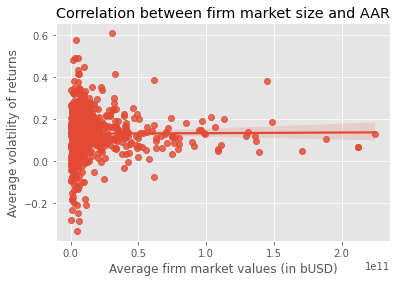

In [284]:
sns.regplot(x = pd.Series(eu_firm_market_values.mean(), name='Average firm market values (in bUSD)'), y = pd.Series(eu_firm_returns.mean() * 12, name='Average volatility of returns')).set(title='Correlation between firm market size and AAR')
print(eu_firm_returns.corrwith(eu_firm_market_values, axis=0).mean())

In [283]:
eu_firm_market_values.drop('IE00BLNN3691', axis='columns', inplace=True)
eu_firm_returns.drop('IE00BLNN3691', axis='columns', inplace=True)

C:\Users\mbela\miniconda3\envs\finance37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


-0.23519458907499835


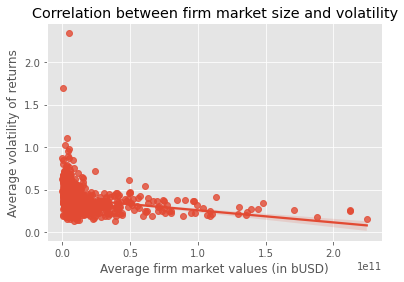

In [285]:
sns.regplot(x = pd.Series(eu_firm_market_values.mean(), name='Average firm market values (in bUSD)'), y = pd.Series(eu_firm_returns.std() * math.sqrt(12), name='Average volatility of returns')).set(title='Correlation between firm market size and volatility')
print((eu_firm_returns.std() * math.sqrt(12)).corr(eu_firm_market_values.mean()).mean())

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 984 and the array at index 1 has size 985

In [108]:
eu_firm_returns.mean().sort_values(ascending=False) * 12


GB0031718066    1.096009
NL0012969182    0.607790
PLDINPL00011    0.575401
PTBES0AM0007    0.492010
GB0030927254    0.489876
                  ...   
IT0005218752   -0.248984
IT0005218752   -0.248984
SE0011256312   -0.283395
BE0974290224   -0.285611
IE00BBGT3753   -0.333834
Length: 985, dtype: float64

<AxesSubplot:>

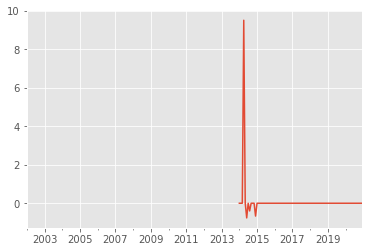

In [111]:
eu_firm_returns['GB0031718066'].plot()

## Question 8

For this question, take the same 50 selected firms. You now create a minimum variance portfolio with monthly rebalancing with an additional constraint: you exclude the smallest firms (bottom tercile of the distribution of the firms' market capitalization in month t − 1). Report summary statistics on the performance of this portfolio and comment on the differences with the minimum variance from point 4. (15 points)

In [ ]:
"""
eu_firm_market_values_50 = eu_firm_market_values.sample(n = 50, axis = 'columns')
eu_firm_market_values_50_top = pd.DataFrame(index = eu_firm_market_values_50.index)

for index, row in eu_firm_market_values_50.iterrows():

    eu_firm_market_values_50_top.iloc[index] =
"""

## Question 9
For each time period, sort firms based on size into quintiles. Create equally-weighted and value-weighted portfolios for each time period and each size quintile. Report the average returns for each quintile portfolio as well as a portfolio that goes long in the lowest quintile and short the highest quintile. Comment on your results. What can explain the relationship between returns of your portfolio and rms' size? Repeat this exercise but sorting rms based on past stock returns. Compute past returns in month as the cumulated return of a rm between months t − 13 and t − 1. (15 points)

Creating quintile groups

In [160]:
quintile_weights = pd.DataFrame(index=eu_firm_market_values.index, columns=eu_firm_market_values.columns)

for index, row in eu_firm_market_values.iterrows():
    quintile_weights.loc[index] = pd.qcut(row, 5, labels=[1, 2, 3, 4, 5])

### Equally weighted portfolios within quintiles

In [118]:
equal_quintile_portfolios = pd.DataFrame()

for i in [1.0, 2.0, 3.0, 4.0, 5.0]:
    quintile_equal_weights = pd.DataFrame(index=eu_firm_market_values.index, columns=eu_firm_market_values.columns)
    for index, row in quintile_weights[quintile_weights == i].iterrows():
        # We have to divide row by row to force skipping NaN values
        quintile_equal_weights.loc[index] = (row / (row * row.count())).T

    portfolio_results = quintile_equal_weights * eu_firm_returns
    equal_quintile_portfolios['Quintile ' + str(i)] = portfolio_stats(portfolio_results, "").sum(axis=0)

### Value-weighted portfolios within quintiles

In [268]:
value_quintile_portfolios = pd.DataFrame()

for i in [1.0]:
    quintile_value_weights = pd.DataFrame(index=eu_firm_market_values.index, columns=eu_firm_market_values.columns)
    for index, row in eu_firm_market_values.iterrows():
        quintile_market_value = row[quintile_weights.loc[index] == i].sum()
        new_row = row[quintile_weights.loc[index] == i] / quintile_market_value
        print(index.year)
        quintile_value_weights.loc[index] = new_row

    portfolio_results = quintile_value_weights * eu_firm_returns
    value_quintile_portfolios['Quintile ' + str(i)] = portfolio_stats(portfolio_results, "").sum(axis=0)

ValueError: cannot reindex from a duplicate axis

In [157]:
eu_firm_market_values.loc[pd.to_datetime('2008-01-31')][quintile_weights.loc[pd.to_datetime('2008-01-31')] == 1.0].sum()

193745123300.0

In [84]:
eu_firm_market_values.loc[pd.to_datetime('2008-01-31')][quintile_weights.loc[pd.to_datetime('2008-01-31')] == 5.0].sum()

8953603800000.0

In [270]:
eu_firm_market_values.columns.is_unique

True

In [246]:
eu_firm_market_values.columns.is_unique

False

In [213]:
new_row.columns

AttributeError: 'Series' object has no attribute 'columns'